In [1]:
#Import libraries
import os
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

Goal here: make a fingerprint of delta masses for control vs treatment and then subtract control fingerprint from treatment fingerprint

# PXD022545

## Intensity based

### Calculations

In [2]:
cols = ['Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03']

In [3]:
PXD022545 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD022545/new_quatn/QuantifiedPeptides.tsv", sep="\t")
PXD022545.drop(list(PXD022545.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD022545 = PXD022545[~PXD022545["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [4]:
OA.quantile_transform(PXD022545, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17
0,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,3.747275,3.603899,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAGDSDSWDADAFSVEDPVRK12|[5]Carbamyl[S],AAAAAAAGDSDSWDADAFSVEDPVRK,EIF3J_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAALQAKnan,AAAAAAALQAK,RL4_HUMAN,NaN,NaN,6.370403,6.033333,6.732039,6.238762,5.956871,6.602602,NaN
3,AAAAADGPPAADGEDGQDPHSK4|semi_tryptic,AAAAADGPPAADGEDGQDPHSK,TXND5_HUMAN,NaN,NaN,2.850465,4.563751,3.758288,4.082936,3.420915,2.959491,NaN
4,AAAAADLANRnan,AAAAADLANR,NaN,NaN,NaN,3.880936,4.493210,4.140690,4.466974,4.256666,4.205373,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34439,YYTVFDRDNNRnan,YYTVFDRDNNR,CATD_HUMAN,NaN,NaN,4.211243,3.893778,NaN,5.983841,6.133266,6.016473,NaN
34440,YYTVFDRnan,YYTVFDR,CATD_HUMAN,NaN,NaN,6.513738,6.685640,6.650354,6.753311,6.599146,6.675384,NaN
34441,YYVTIIDAPGHRDFIKnan,YYVTIIDAPGHRDFIK,NaN,NaN,NaN,5.264041,5.515966,5.915349,4.702836,2.636120,5.719961,NaN
34442,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,6.745842,6.829568,7.083108,6.600170,6.325088,7.113736,NaN


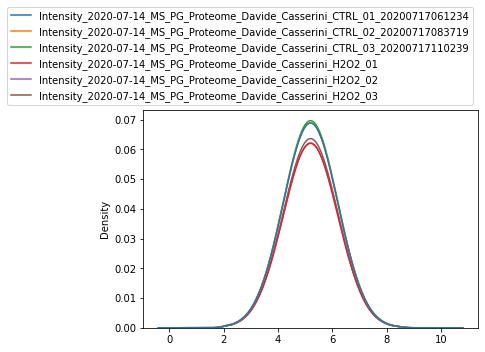

In [5]:
ax = sns.kdeplot(data=PXD022545[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [6]:
db = pymass.Unimod()

In [7]:
def modifications(seq):
    if seq.endswith("nan"):
        return None
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            for i in matches:
                return [i for i in matches]
                
def get_delta_mass(seq):
    
    if seq.endswith("nan"):
        return 0
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            delta_mass = 0
            for i in matches:
                    for p in range(len(db.mods)):
                        if db.mods[p]['record_id'] == float(i):
                
                            mm = db.mods[p]['mono_mass']
                            # mm = db.mods[p]['delta_mono_mass']
                            delta_mass += mm
                            delta_mass = round(delta_mass, 2)
            return delta_mass
        else:
            return 0
                    

                

In [8]:
PXD022545["Modifications"] = PXD022545["Sequence"].apply(modifications)
PXD022545["Delta_mass"] = PXD022545["Sequence"].apply(get_delta_mass)

In [9]:
No_zero = PXD022545[PXD022545["Delta_mass"] != 0]

In [10]:
# g = No_zero.groupby("Delta_mass").median().reset_index()
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [11]:

from statistics import median


g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "CTRL" in c]),axis=1)
g["medianH2O2"]=g.apply(lambda x:median([x[c] for c in g.columns if "H2O2" in c]), axis=1)
# g['Quotient']=(g["medianH2O2"] - g["medianCtrl"]) / max([g["medianCtrl"], g["medianH2O2"]])
# g["Quotient"] = ((g["medianH2O2"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianH2O2"], other=(g["medianH2O2"] - g["medianCtrl"])/ g["medianH2O2"])
# g["Quotient"] = ((g["medianH2O2"] - g["medianCtrl"])/ g["medianH2O2"]).where( g["medianCtrl"] < g["medianH2O2"])
g["Difference"] = (g["medianH2O2"] - g["medianCtrl"])

In [12]:
# gfiltered = g[(g["medianCtrl"] !=0) & (g["medianH2O2"] !=0) ]


### Plots

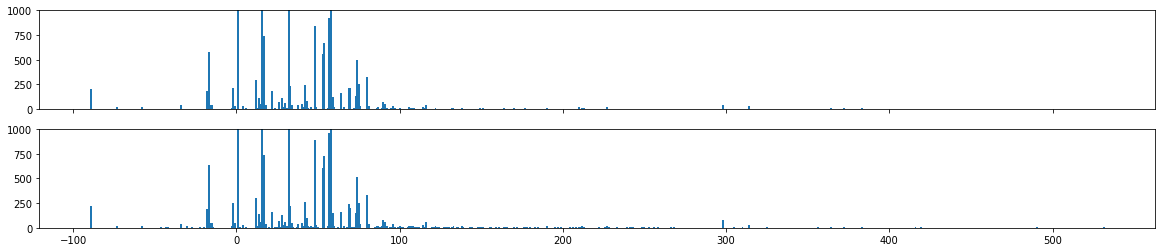

In [13]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianH2O2, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,1000)
plt.show()

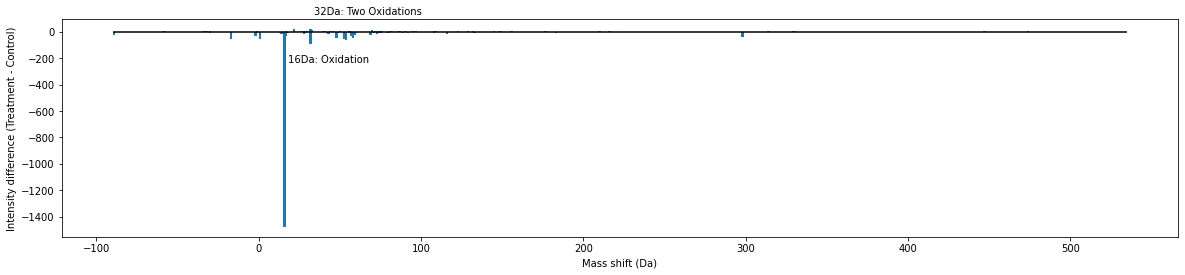

In [14]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.text(x= 18, y= -230, s= "16Da: Oxidation")
plt.text(x=34, y= 130, s="32Da: Two Oxidations")
plt.show()

In [15]:
# gfiltered["Quotient"].replace(np.inf, np.nan, inplace=True)
# gfiltered["Quotient"].replace(np.nan, 0, inplace=True)
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [16]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
64,21.98,0.0,0.0,162.627709,187.314212,160.778744,181.969768,181.779285,170.138352,0.0,162.627709,181.779285,19.151576
83,31.98,0.0,0.0,3049.060511,3052.358388,2965.372114,3147.015463,3019.433371,3067.597334,0.0,3049.060511,3067.597334,18.536823
86,33.02,0.0,0.0,214.265245,218.334951,223.404294,215.430484,261.799205,230.093561,0.0,218.334951,230.093561,11.758609
171,69.91,0.0,0.0,223.979725,199.524692,193.442208,211.258408,195.263020,213.379020,0.0,199.524692,211.258408,11.733716
72,28.03,0.0,0.0,80.884643,67.222607,69.921700,75.206790,78.347713,80.325593,0.0,69.921700,78.347713,8.426013
7,-33.99,0.0,0.0,36.108799,38.587993,42.010507,50.298714,46.196095,43.315219,0.0,38.587993,46.196095,7.608102
103,40.03,0.0,0.0,58.602304,38.254111,44.617929,50.258549,66.321042,51.748789,0.0,44.617929,51.748789,7.130860
432,210.00,0.0,0.0,20.278632,12.553389,12.154060,12.652595,19.341000,19.732881,0.0,12.553389,19.341000,6.787610
232,94.97,0.0,0.0,3.811285,8.676785,4.182515,9.964489,13.778243,10.828991,0.0,4.182515,10.828991,6.646476
176,72.02,0.0,0.0,8.192083,3.089431,4.123556,10.729793,11.396935,4.714641,0.0,4.123556,10.729793,6.606237


21.981943: Sodium adduct

31.989830: Two Oxidations!

33.021464: Ammonium + Oxidation

75.012042: Fluoro + Carbamidomethylation

69.91: Oxidation + Replacement of 2 protons by iron

28.03: Acetaldehyde adduct or dimethylation or ethylation 

-33.99: Dehydroalanine (from Cysteine)	

40.031300: Propionaldehyde adduct

210: carboxymethyldtt

94.97: sulfo + anmino

72.02: whole lot of stuff


In [17]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
147,58.00,0.0,0.0,502.398523,533.158568,444.044419,465.123549,450.326817,466.228326,0.0,502.398523,465.123549,-37.274974
488,298.15,0.0,0.0,83.956147,86.792781,72.755921,42.820520,48.021022,36.904467,0.0,83.956147,42.820520,-41.135627
125,47.98,0.0,0.0,897.282502,860.908123,885.238281,851.849218,841.861780,795.875544,0.0,885.238281,841.861780,-43.376501
148,58.01,0.0,0.0,2478.353275,2454.329720,2415.319354,2200.810452,2410.316874,2427.163963,0.0,2454.329720,2410.316874,-44.012846
132,52.91,0.0,0.0,614.659419,608.869631,574.111767,573.503255,526.127718,557.005392,0.0,608.869631,557.005392,-51.864239
35,0.98,0.0,0.0,1879.787167,1869.891715,1859.168324,1807.750550,1835.652734,1812.795393,0.0,1869.891715,1812.795393,-57.096323
21,-17.03,0.0,0.0,646.391917,629.949771,637.158179,579.058899,580.052685,566.507257,0.0,637.158179,579.058899,-58.099280
134,53.92,0.0,0.0,758.317774,728.866368,682.648806,706.348038,604.161810,667.395467,0.0,728.866368,667.395467,-61.470901
84,31.99,0.0,0.0,916.073180,1029.965013,1079.221243,958.430033,922.786717,940.849195,0.0,1029.965013,940.849195,-89.115817
54,15.99,0.0,0.0,18437.279922,18436.445608,18940.530132,16960.019021,16859.728056,17381.763669,0.0,18437.279922,16960.019021,-1477.260901


15.994915: Oxidation

31.99: dioxidation

53.92: Replacement of 2 protons by iron

-17.026549: Ammonium loss

0.984016: Deamidation

52.91: Replacement of 3 protons by iron

58.01: carboxymethyl

47.98: Trioxidation

298.146347: biotin hydrazide labeled acrolein addition

58.00: Carbamidomethylation + deamidated

# PXD012477

## Intensity based

### Pre-calculations

In [18]:
PXD012477 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD012477/flashlfq_results/QuantifiedPeptides.tsv", sep="\t")
PXD012477.drop(list(PXD012477.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD012477.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,...,Intensity_1DLC122214QE_RRAG_036_rep1,Intensity_1DLC060615QE_RRAG_037B_rep3,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,7.056849e+05,0.000000,0.0,1.097085e+06,0.0,108828.848060,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,308918.957796,211139.976308,459861.238281,0.0,1.235488e+06,...,1.319586e+06,0.0,0.0,1.874100e+06,191749.419922,0.0,0.000000e+00,0.0,349322.769137,NaN


In [19]:
cols =[]
for i in PXD012477.columns[5:-1]:
    cols.append(i)

In [20]:
OA.quantile_transform(PXD012477, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,...,Intensity_1DLC122214QE_RRAG_036_rep1,Intensity_1DLC060615QE_RRAG_037B_rep3,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.449100,NaN,NaN,5.442738,NaN,5.285466,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,5.944845,5.401439,5.976326,NaN,6.076366,...,6.144283,NaN,NaN,6.078776,5.923122,NaN,NaN,NaN,5.870449,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102383,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[100...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102384,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[131...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102385,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[6]C...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102386,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[999...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
PXD012477["Modifications"] = PXD012477["Sequence"].apply(modifications)
PXD012477["Delta_mass"] = PXD012477["Sequence"].apply(get_delta_mass)

In [22]:
No_zero = PXD012477[PXD012477["Delta_mass"] != 0]

In [23]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [24]:
g

,Delta_mass,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,Intensity_1DLC123114QE_RRAG_064_rep4,Intensity_1DLC121514QE_RRAG_017_rep2,...,Intensity_1DLC122214QE_RRAG_036_rep1,Intensity_1DLC060615QE_RRAG_037B_rep3,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983
0,-94.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,10.556163,11.460536,5.295340,...,0.000000,0.000000,5.570136,4.497380,0.000000,4.520445,3.998804,0.000000,5.135973,0.0
1,-89.03,0.0,0.0,104.603918,103.832718,107.684593,108.565274,98.732190,107.101896,77.030084,...,99.912408,80.635199,113.793435,84.002060,78.587012,36.237200,65.227054,87.889781,108.395455,0.0
2,-78.05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-73.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.048061,...,4.967573,0.000000,8.225911,0.000000,0.000000,5.739271,5.172817,4.793559,5.069788,0.0
4,-58.01,0.0,0.0,44.922524,71.932402,76.975417,44.817996,40.065190,45.131661,59.760470,...,53.030136,24.181923,32.039338,18.435391,67.178846,44.716188,38.008172,36.554472,54.367655,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,557.24,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1495,563.18,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1496,587.26,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1497,588.29,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [25]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,66):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = g[[col for col in g if patient in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = g[[col for col in g if patientB in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patientB] = selectedB

In [26]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [27]:
data = pd.DataFrame()
data["Delta_mass"] = g["Delta_mass"]
for patient in dict:
    data[patient] = dict[patient]["median"]

In [28]:
data.dropna(axis=1, inplace=True)
data

,Delta_mass,_001_,_002_,_003_,_004_,_005_,_006_,_007_,_008_,_009_,...,_053B_,_054B_,_055B_,_056B_,_058B_,_059B_,_060B_,_061B_,_062B_,_064B_
0,-94.04,0.000000,0.000000,0.000000,0.000000,0.000000,4.492536,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.938689,4.883841,2.205575,5.562257
1,-89.03,54.292990,34.761547,68.595441,59.216523,88.762659,70.549571,75.797006,67.840313,96.064153,...,85.619869,54.689095,66.956228,114.911284,95.202407,33.569461,101.264528,109.333153,84.369397,112.118045
2,-78.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-73.04,0.000000,0.000000,0.000000,5.055459,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.276985,4.962008,5.082430,0.000000,4.925819,0.000000,0.000000,2.148734,0.000000
4,-58.01,16.919775,23.179227,33.209143,14.551972,38.388103,40.010477,39.647503,48.632541,48.622696,...,38.043472,37.404894,37.279147,47.154424,40.188925,31.749702,45.455467,52.292151,39.900646,35.194569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,557.24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1495,563.18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1496,587.26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1497,588.29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["Delta_mass"] = data["Delta_mass"]
NonHealthydf["Delta_mass"] = data["Delta_mass"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in data.columns:
        Healthydf[i] = data[i]
for i in patienBlist:
    if i in data.columns:
        Healthydf[i] = data[i]


patielist = []
patieBlist = []
data["Delta_mass"] = g["Delta_mass"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in data.columns:
        NonHealthydf[i] = data[i]
for i in patieBlist:
    if i in data.columns:
        NonHealthydf[i] = data[i]

In [30]:
Healthydf.set_index("Delta_mass",inplace=True)
Healthy = Healthydf.median(axis=1).to_frame().reset_index()

NonHealthydf.set_index("Delta_mass", inplace=True)
NonHealthy = NonHealthydf.median(axis=1).to_frame().reset_index()


In [31]:
data = pd.merge(Healthy, NonHealthy, how="outer", on=["Delta_mass", "Delta_mass"], suffixes=["H","NH"])

In [32]:
data

,Delta_mass,0H,0NH
0,-94.04,0.000000,0.000000
1,-89.03,87.890561,78.216702
2,-78.05,0.000000,0.000000
3,-73.04,0.000000,0.000000
4,-58.01,41.691249,39.900646
...,...,...,...
1494,557.24,0.000000,0.000000
1495,563.18,0.000000,0.000000
1496,587.26,0.000000,0.000000
1497,588.29,0.000000,0.000000


In [33]:
# data["Quotient"] = ((data["0NH"] - data["0H"])/ data["0H"]).where( data["0H"] >= data["0NH"], other=(data["0NH"] - data["0H"])/ data["0NH"])
data["Difference"] = data["0NH"] - data["0H"]
# data.fillna(0, inplace=True)
# g["Quotient"] = ((g["meanNH"] - g["meanH"])/ g["meanNH"]).where( g["meanH"] < g["meanNH"])


### Plots

In [34]:
data

,Delta_mass,0H,0NH,Difference
0,-94.04,0.000000,0.000000,0.000000
1,-89.03,87.890561,78.216702,-9.673859
2,-78.05,0.000000,0.000000,0.000000
3,-73.04,0.000000,0.000000,0.000000
4,-58.01,41.691249,39.900646,-1.790603
...,...,...,...,...
1494,557.24,0.000000,0.000000,0.000000
1495,563.18,0.000000,0.000000,0.000000
1496,587.26,0.000000,0.000000,0.000000
1497,588.29,0.000000,0.000000,0.000000


In [35]:
# datafiltered = data[(data["0H"] !=0) & (data["0NH"] !=0) ]


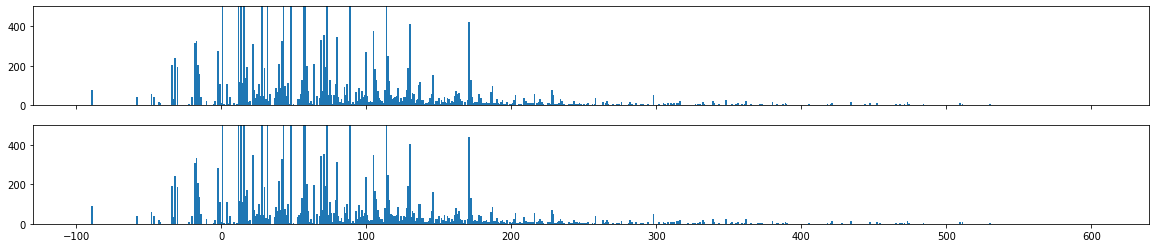

In [36]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=data.Delta_mass, height=data["0NH"], width=1.2)
ax2.bar(x=data.Delta_mass, height=data["0H"], width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,500)
plt.show()

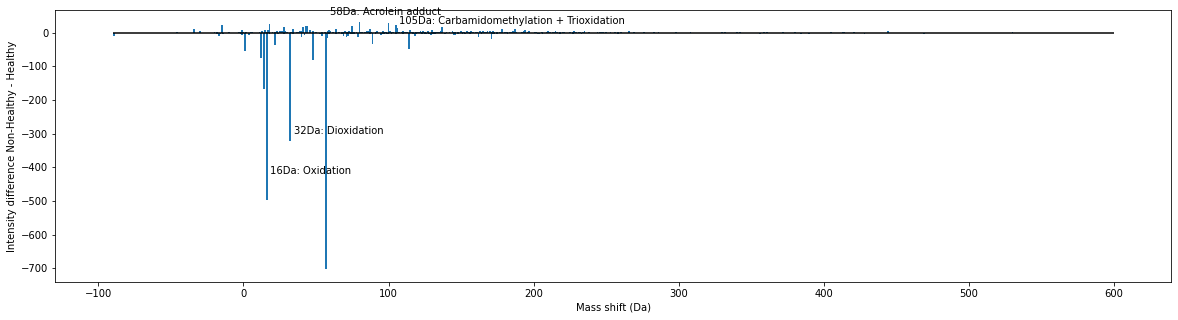

In [37]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=data.Delta_mass, height=data.Difference, width=1.2)
fig.set_size_inches(20,5)
plt.hlines(y=0,xmin=-90, xmax=600, color="k")
plt.ylabel("Intensity difference Non-Healthy - Healthy")
plt.xlabel("Mass shift (Da)")
plt.text(x=60,y=52,s="58Da: Acrolein adduct")
plt.text(x=18, y = -420, s="16Da: Oxidation")
plt.text(x = 107, y=25, s= "105Da: Carbamidomethylation + Trioxidation")
plt.text(x=35, y = -300, s="32Da: Dioxidation")

# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [38]:
sorted = data.sort_values(by="Difference", axis=0, ascending=False)

In [39]:
sorted.head(10)

,Delta_mass,0H,0NH,Difference
285,79.97,314.542679,345.281459,30.738780
365,100.03,237.828790,267.103930,29.275140
76,17.99,168.521935,195.204810,26.682875
393,105.00,349.543536,373.292110,23.748574
29,-15.01,136.395551,158.083783,21.688232
261,75.01,107.852466,129.157356,21.304890
141,43.01,976.317108,996.630278,20.313170
145,43.99,76.263073,95.955644,19.692571
136,41.03,71.722254,88.286088,16.563834
546,136.99,102.351563,117.994772,15.643209


79.97: Phosphorylation

100.027278: Carbamidomethylation + Carbamyl

17.990578: fluorination

105.006208: Carbamidomethylation + Trioxidation

-15.01: lactic acid from N-term Ser

58.041865: Reduced acrolein addition +58	

75.01: carbamidomethylation + fluorination

43.01: Carbamyl

43.99: Carboxylation

41.03: amidination or carbamidomethylation + deoxydation

136.99: Carbamidomethylation + phosphorylation

In [40]:
PXD012477[PXD012477["Delta_mass"] == 114.04]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,...,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983,Modifications,Delta_mass
61,AACCLAGAR3|[121]GG[C],AACCLAGAR,6PGL_HUMAN,NaN,NaN,5.456652,NaN,NaN,5.875624,5.756718,...,4.759444,NaN,NaN,5.029520,NaN,NaN,5.450583,NaN,[121],114.04
63,AACCLAGAR4|[121]GG[C],AACCLAGAR,6PGL_HUMAN,NaN,NaN,NaN,4.853634,4.840923,NaN,NaN,...,NaN,4.781952,NaN,NaN,NaN,5.299157,4.628715,NaN,[121],114.04
72,AACGPSSCYALFPR3|[4]carbamidomethyl[C]|6|[1263]...,AACGPSSCYALFPR,CD248_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 1263]",114.04
73,AACGPSSCYALFPR3|[4]carbamidomethyl[C]|6|[4]Car...,AACGPSSCYALFPR,CD248_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4]",114.04
75,AACGPSSCYALFPR3|[4]carbamidomethyl[C]|7|[1263]...,AACGPSSCYALFPR,CD248_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.970415,NaN,NaN,NaN,NaN,"[4, 1263]",114.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102245,YYPLGQTFYPGPGCDSLCR14|[4]carbamidomethyl[C]|16...,YYPLGQTFYPGPGCDSLCR,FCGBP_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4]",114.04
102246,YYPLGQTFYPGPGCDSLCR14|[4]carbamidomethyl[C]|18...,YYPLGQTFYPGPGCDSLCR,FCGBP_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4]",114.04
102377,YYYVCQYCPAGNWANR5|[4]carbamidomethyl[C]|7|[4]C...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,5.084289,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4]",114.04
102378,YYYVCQYCPAGNWANR5|[4]carbamidomethyl[C]|8|[4]c...,YYYVCQYCPAGNWANR,;CRIS3_HUMAN,NaN,NaN,NaN,4.607097,NaN,4.875813,5.049631,...,4.701581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4]",114.04


In [41]:
sorted.tail(10)

,Delta_mass,0H,0NH,Difference
84,21.98,345.663098,309.465990,-36.197108
434,114.04,2343.183357,2294.085668,-49.097689
49,0.98,2276.509486,2221.998577,-54.510909
110,31.98,615.080047,550.144699,-64.935349
59,12.00,1553.218936,1479.183447,-74.035489
162,47.98,1839.345575,1757.576999,-81.768576
66,13.98,1692.165938,1524.140430,-168.025508
111,31.99,3241.602385,2921.159674,-320.442711
73,15.99,6420.257009,5923.882081,-496.374928
192,57.02,10090.141178,9386.641899,-703.499279


57.021464: Carbamidomethylation

15.994915: Oxidation

31.989829: Dioxidation

13.97926: Carbonylation 

47.984744: Trioxidation

12: formaldehyde adduct

31.98: two oxidations

0.984016: Deamidation

114.04: whole lot of stuf

21.981943: Sodium adduct		


# PXD016278

## Intensity based

### Calculations

In [102]:
PXD016278 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD016278/flashlfq/QuantifiedPeptides.tsv", sep="\t")
PXD016278.drop(list(PXD016278.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD016278.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,6.157306e+05,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,3.159841e+06,194429.501953,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,1.407283e+06,1.882486e+06,0.0,0.0,0.0,0.0,0.0,2.078671e+07,0.0,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,4.562765e+06,8516465.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN


In [103]:
cols =[]
for i in PXD016278.columns[5:-1]:
    cols.append(i)

In [104]:
OA.quantile_transform(PXD016278, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.448575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,5.523535,4.079077,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.621402,5.200138,NaN,NaN,NaN,NaN,NaN,5.988449,NaN,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,5.583702,5.882425,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108603,YYYAVYDMVVR8|[35]oxidation[M],YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108604,YYYAVYDMVVRnan,YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.266314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108605,YYYDGKDYIEFNK6|[4]Carbamidomethyl[K],YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.461308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108606,YYYDGKDYIEFNKnan,YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
PXD016278["Modifications"] = PXD016278["Sequence"].apply(modifications)
PXD016278["Delta_mass"] = PXD016278["Sequence"].apply(get_delta_mass)

In [106]:
No_zero = PXD016278[PXD016278["Delta_mass"] != 0]

In [107]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [108]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,-94.04,0.0,0.0,0.000000,0.000000,0.000000,5.209070,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.700149,0.000000,0.000000,0.000000,0.000000,0.0
1,-89.03,0.0,0.0,0.000000,5.144097,5.034387,5.740346,22.631898,27.537924,4.929256,...,3.609254,4.871164,4.404596,5.988312,15.474873,22.832234,4.714633,0.000000,0.000000,0.0
2,-73.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.598296,3.883334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-58.01,0.0,0.0,0.000000,0.000000,0.000000,5.850834,0.000000,0.000000,0.000000,...,0.000000,7.596156,13.461194,6.029455,0.000000,0.000000,0.000000,5.557409,5.030884,0.0
4,-48.00,0.0,0.0,21.532038,19.244180,37.747370,17.995030,22.596779,30.154635,41.081439,...,38.776144,45.861870,56.473630,30.945879,20.392057,36.582895,19.158991,43.149413,31.167221,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,561.24,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1400,563.18,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1401,568.25,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1402,572.20,0.0,0.0,0.000000,0.000000,4.691205,8.817206,12.007055,12.212218,15.762632,...,5.345514,0.000000,10.340784,19.237611,16.626263,0.000000,5.961614,4.451615,5.392434,0.0


In [109]:
from statistics import median
g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "ctrl2" in c]),axis=1)
g["medianAD"]=g.apply(lambda x:median([x[c] for c in g.columns if "AD2" in c]), axis=1)

In [110]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD
0,-94.04,0.0,0.0,0.000000,0.000000,0.000000,5.209070,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.700149,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,-89.03,0.0,0.0,0.000000,5.144097,5.034387,5.740346,22.631898,27.537924,4.929256,...,4.404596,5.988312,15.474873,22.832234,4.714633,0.000000,0.000000,0.0,4.792878,5.068499
2,-73.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.598296,3.883334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,-58.01,0.0,0.0,0.000000,0.000000,0.000000,5.850834,0.000000,0.000000,0.000000,...,13.461194,6.029455,0.000000,0.000000,0.000000,5.557409,5.030884,0.0,2.515442,0.000000
4,-48.00,0.0,0.0,21.532038,19.244180,37.747370,17.995030,22.596779,30.154635,41.081439,...,56.473630,30.945879,20.392057,36.582895,19.158991,43.149413,31.167221,0.0,31.863609,29.689249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,561.24,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1400,563.18,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1401,568.25,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1402,572.20,0.0,0.0,0.000000,0.000000,4.691205,8.817206,12.007055,12.212218,15.762632,...,10.340784,19.237611,16.626263,0.000000,5.961614,4.451615,5.392434,0.0,4.470993,4.777449


In [111]:
# g["Quotient"] = ((g["medianAD"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianAD"], other=(g["medianAD"] - g["medianCtrl"])/ g["medianAD"])

In [112]:
g["Difference"] = g["medianAD"] - g["medianCtrl"]

In [113]:
# g["Quotient"].replace(np.nan, 0, inplace=True)

In [114]:
# gfiltered = g[(g["medianCtrl"] !=0) & (g["medianH2O2"] !=0) ]


### Plots

In [115]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
0,-94.04,0.0,0.0,0.000000,0.000000,0.000000,5.209070,0.000000,0.000000,0.000000,...,0.000000,5.700149,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,-89.03,0.0,0.0,0.000000,5.144097,5.034387,5.740346,22.631898,27.537924,4.929256,...,5.988312,15.474873,22.832234,4.714633,0.000000,0.000000,0.0,4.792878,5.068499,0.275621
2,-73.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.598296,3.883334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,-58.01,0.0,0.0,0.000000,0.000000,0.000000,5.850834,0.000000,0.000000,0.000000,...,6.029455,0.000000,0.000000,0.000000,5.557409,5.030884,0.0,2.515442,0.000000,-2.515442
4,-48.00,0.0,0.0,21.532038,19.244180,37.747370,17.995030,22.596779,30.154635,41.081439,...,30.945879,20.392057,36.582895,19.158991,43.149413,31.167221,0.0,31.863609,29.689249,-2.174361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,561.24,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1400,563.18,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1401,568.25,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1402,572.20,0.0,0.0,0.000000,0.000000,4.691205,8.817206,12.007055,12.212218,15.762632,...,19.237611,16.626263,0.000000,5.961614,4.451615,5.392434,0.0,4.470993,4.777449,0.306456


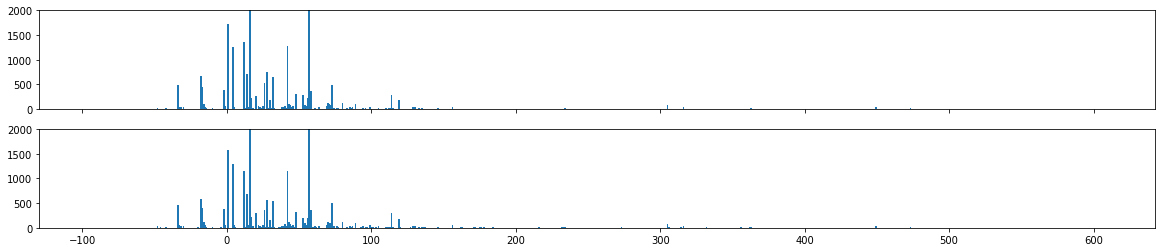

In [116]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianAD, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,2000)
plt.show()

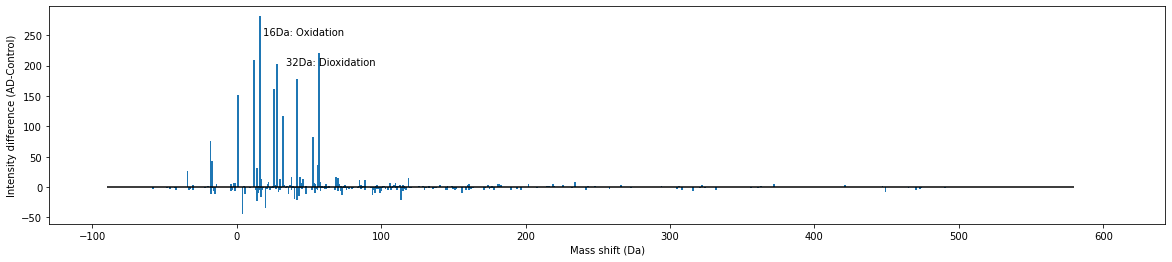

In [117]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.2)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=580, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (AD-Control)")
plt.text(x=18, y= 250, s= "16Da: Oxidation")
plt.text(x=34, y= 200, s="32Da: Dioxidation")
# plt.text(x=55, y=50, s= "53Da: Replacement of 2 protons by iron")
# plt.text(x=44, y = -100, s="42Da: Tri-methylation")
# plt.text(x=16, y = -70, s="14Da: Methylation")
# plt.text(x=-90, y=-60, s="4Da: Tryptophan oxidation \n to kynurenin")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [118]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [119]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
71,15.99,0.0,0.0,2678.386588,2670.451371,4103.305756,4543.077276,4549.241702,5124.631189,3991.113369,...,4155.018519,3995.849174,3745.256823,3103.417187,3299.853938,3886.800735,0.0,3883.809051,4165.197114,281.388062
196,57.02,0.0,0.0,2007.072895,1946.369926,2982.429880,3261.639858,2906.486311,2996.422736,2669.005481,...,3191.945662,3455.679991,3171.838587,2481.793526,2650.347310,3044.152737,0.0,3332.042061,3552.929585,220.887524
56,12.00,0.0,0.0,532.652964,727.414178,1043.171443,1035.517518,871.942602,873.059255,847.403676,...,1119.752670,1236.657125,1086.123029,876.372843,1008.016909,1167.506741,0.0,1140.114128,1349.951756,209.837628
95,27.99,0.0,0.0,1124.213625,472.311619,598.413935,666.569897,567.948176,591.888520,621.160880,...,636.516309,593.595043,546.243479,384.219070,485.756716,656.989156,0.0,557.090310,759.763713,202.673403
141,42.01,0.0,0.0,246.508961,298.860576,363.470772,262.505351,217.217654,284.236223,177.290711,...,346.231127,335.083512,326.641519,304.532049,362.669583,377.446032,0.0,315.586784,492.930841,177.344057
89,26.02,0.0,0.0,189.952234,171.302898,312.006729,296.634867,280.427643,283.268967,304.593586,...,440.175925,525.236873,406.535623,326.627073,330.121381,441.172608,0.0,362.054982,523.826561,161.771579
47,0.98,0.0,0.0,1155.335158,947.176337,1556.051930,1678.578116,1611.773864,1606.716455,1579.019648,...,1741.670968,1874.915669,1691.500177,1473.664993,1521.789301,1734.481916,0.0,1578.419461,1729.651000,151.231539
143,42.05,0.0,0.0,521.581570,552.172265,719.617324,685.930152,714.038800,785.284048,841.803001,...,1617.183306,1713.431306,1313.357688,618.269308,772.485437,1350.009922,0.0,1143.827360,1274.432676,130.605315
111,31.99,0.0,0.0,432.585515,469.567932,553.155442,687.095255,693.683120,724.593594,780.339869,...,541.866872,501.383499,474.244342,449.002483,443.356689,601.781614,0.0,543.205093,659.691214,116.486120
96,28.03,0.0,0.0,131.916517,202.024758,254.614318,233.368691,194.368687,248.019747,213.685332,...,409.389219,339.078037,268.252207,265.150748,216.632099,361.037641,0.0,285.676816,382.612557,96.935741


15.994915: Oxidation (yes)

57.02: carbamidomethyl 

12: formaldehyde adduct	(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6878761/)

27.994915: Formylation (can't find anything, Unimod says this is artefact)

42.010565: Acetylation (can't really find anything)

26.015650: Acetaldehyde adduct (Aldehyde metabolism is impaired in AD but maybe a stretch)

0.98: deamidation 

52.911464: Replacement of 3 protons by iron	 (iron accumulation is definitely associated but AD but maybe a stretch)

42.05: trimethylation

31.989829: Dioxidation (yes)

28.031300: Acetaldehyde +28	adduct (Again!)

In [120]:
PXD016278[PXD016278["Delta_mass"] == 57.02]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,Modifications,Delta_mass
34,AAAGIQPPGYLIHESACWSDTLQR17|[4]carbamidomethyl[C],AAAGIQPPGYLIHESACWSDTLQR,CANT1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
36,AAAIGIDLGTTYSCVGVFQHGK14|[4]carbamidomethyl[C],AAAIGIDLGTTYSCVGVFQHGK,HS71A_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.685869,NaN,[4],57.02
47,AAALKLTLASVR5|[4]Carbamidomethyl[K],AAALKLTLASVR,NRX1A_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.840333,3.011507,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
61,AAAQCYIDLIIK5|[4]carbamidomethyl[C],AAAQCYIDLIIK,COPB_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
70,AACALLNSGGGVIR3|[4]carbamidomethyl[C],AACALLNSGGGVIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108569,YYTYLIMNK2|[4]Carbamidomethyl[Y],YYTYLIMNK,CO3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.860880,NaN,[4],57.02
108586,YYTYLIMNKGR9|[4]Carbamidomethyl[K],YYTYLIMNKGR,CO3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.621887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
108590,YYVDSVKGR7|[4]Carbamidomethyl[K],YYVDSVKGR,HV307_HUMAN,NaN,NaN,NaN,NaN,6.261339,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
108594,YYVTIIDAPGHR2|[4]Carbamidomethyl[Y],YYVTIIDAPGHR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02


In [121]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
260,73.01,0.0,0.0,281.323703,285.665834,484.674827,577.427778,534.300791,585.694984,454.629876,...,388.514034,465.617949,401.160596,382.139085,396.415078,454.039952,0.0,495.753780,481.963735,-13.790044
146,43.04,0.0,0.0,9.869777,15.535530,96.923657,96.401943,28.250185,38.306011,33.733108,...,85.088756,88.670364,46.616354,35.638388,50.900697,83.500747,0.0,76.319394,62.353159,-13.966235
145,43.01,0.0,0.0,77.860649,70.626118,145.381701,106.548624,103.302835,89.266620,95.274033,...,117.023938,117.451808,93.137398,92.013101,130.540190,126.800102,0.0,116.772661,101.877069,-14.895592
73,17.03,0.0,0.0,48.495091,48.666104,96.568016,74.741256,40.959984,46.579194,24.014632,...,42.361711,61.112922,45.623089,39.205781,29.102690,70.362827,0.0,64.112828,48.580598,-15.532231
137,40.03,0.0,0.0,15.014127,23.519114,45.891515,28.245045,0.000000,5.946869,15.594373,...,51.934515,75.675037,64.434536,40.013260,26.272013,49.921235,0.0,49.957544,29.926142,-20.031402
142,42.02,0.0,0.0,31.192774,27.537194,97.815279,57.272511,64.312569,70.618606,65.133653,...,74.573453,85.624189,111.308070,101.319476,90.139127,95.664612,0.0,89.420916,68.797190,-20.623726
435,114.04,0.0,0.0,172.133344,151.746395,247.873421,304.372110,212.701670,252.596596,213.311392,...,197.140968,305.382308,330.220854,245.152125,312.787155,332.815509,0.0,306.211735,284.355436,-21.856299
63,13.98,0.0,0.0,134.714423,151.514155,225.753521,335.020026,249.824724,291.017917,354.335822,...,287.211666,312.550470,241.734241,251.547244,306.202325,321.332842,0.0,280.803562,257.541506,-23.262057
77,19.98,0.0,0.0,149.507773,139.947775,237.335707,251.110704,229.046021,260.365719,182.727299,...,317.513317,290.098577,263.718079,198.295384,194.252127,338.311171,0.0,294.152209,260.292455,-33.859754
49,3.99,0.0,0.0,797.424379,924.743753,1001.320281,1272.371151,1270.019505,1366.291893,1239.444727,...,1652.902005,1293.703219,1126.079295,859.040982,878.692638,1471.936454,0.0,1292.938989,1248.746891,-44.192098


3.994915: tryptophan oxidation to kynurenin (Conflicting reports, some say kynurenin pathway is reduced in AD patients, but this is talking about metabolites, can't really find data on protein modificaitons)

19.989830: tryptophan oxidation to hydroxykynurenin

42.046950: tri-methylation

14.015650: methylation

13.98: carbonylation (:-/)

114.042928: Ubiquitination 

42.02: guanidinylation

40.03: Propionaldehyde adduct

43.01: carbamyl

43.04: carboxyl modification with ethanolamine

73.016379: Oxidation + Carbamidomethyl

	



# PXD014381

### Calculations

In [122]:
cols = ['Intensity_QX01983',
       'Intensity_QX01981_160316090220', 'Intensity_QX01867',
       'Intensity_QX01870', 'Intensity_QX01873', 'Intensity_QX01862',
       'Intensity_QX01865', 'Intensity_QX01868', 'Intensity_QX01984',
       'Intensity_QX01874', 'Intensity_QX01860', 'Intensity_QX01863',
       'Intensity_QX01866', 'Intensity_QX01869', 'Intensity_QX01872']

In [123]:
PXD014381 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD014381/mzml_files/QuantifiedPeptides.tsv", sep="\t")
PXD014381.drop(list(PXD014381.filter(regex = 'Detection Type|Unnamed')), axis = 1, inplace = True)
PXD014381 = PXD014381[~PXD014381["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [124]:
OA.quantile_transform(PXD014381, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872
0,AAAAAAAAAAAAAAAAGATCLER20|[935]Atto495Maleimid...,AAAAAAAAAAAAAAAAGATCLER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAAGAAGGR0|[1]Acetyl[N-TERM],AAAAAAAAAAGAAGGR,PABP2_HUMAN,NaN,NaN,NaN,NaN,6.121298,5.834774,5.523748,5.969850,6.008275,5.814900,5.310131,6.111347,5.875306,6.006802,6.001351,6.031433,4.350659
2,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.248033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAVPSAGPAGPAPTSAAGR0|[9999530]Methyl_2H(...,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,4.591761,4.455139,4.479478,4.110906,4.311641,4.294662,4.883361,4.690469,4.427945,4.772457,3.814937,3.621315,4.745856,4.482498,4.514642
4,AAAAAAAAVPSAGPAGPAPTSAAGRnan,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,5.164943,5.006685,5.240198,5.295028,5.566057,5.232198,5.265588,5.261213,4.935918,5.523181,5.284992,5.187497,5.100125,5.137829,5.381597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39163,YYVTIIDAPGHR2|[4]Carbamidomethyl[Y],YYVTIIDAPGHR,NaN,NaN,NaN,5.489817,6.574731,6.515439,6.427139,3.666679,4.921354,5.515669,5.434582,5.857403,NaN,5.734494,6.082803,5.559171,6.234073,6.162652
39164,YYVTIIDAPGHRDFIK16|[320]Nethylmaleimide+water[K],YYVTIIDAPGHRDFIK,NaN,NaN,NaN,3.133248,6.807918,6.676688,4.847939,5.458636,6.341033,4.844949,6.651371,4.514573,6.710468,3.859167,6.509451,6.445864,4.484046,6.530901
39165,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,7.770552,8.082394,7.970133,7.948876,7.602078,7.994151,8.040760,8.062211,8.117252,8.129415,7.925919,8.089237,7.991904,8.046757,8.075467
39166,YYVTIIDAPNHR10|Gly->Asn[G],YYVTIIDAPNHR,NaN,NaN,NaN,4.016578,NaN,6.442717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


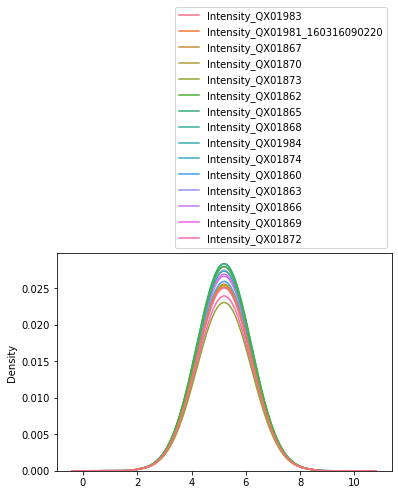

In [125]:
ax = sns.kdeplot(data=PXD014381[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [126]:
PXD014381["Modifications"] = PXD014381["Sequence"].apply(modifications)
PXD014381["Delta_mass"] = PXD014381["Sequence"].apply(get_delta_mass)

In [127]:
No_zero = PXD014381[PXD014381["Delta_mass"] != 0]

In [128]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [129]:
g

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872
0,-94.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-89.03,0.0,0.0,556.695556,534.873071,565.059258,589.521294,483.892530,655.991513,644.425669,667.636726,602.371627,552.138031,593.132866,664.455800,631.189738,606.261823,486.850254
2,-73.04,0.0,0.0,10.714687,11.860366,9.356577,11.626765,9.394935,15.871039,10.016941,9.457495,11.821542,15.381116,23.719978,10.735612,16.783754,5.873826,5.818493
3,-58.01,0.0,0.0,12.743456,12.647158,12.646187,12.688999,12.524371,13.129031,12.275375,12.202283,13.182881,12.922915,12.141342,13.181215,13.310393,11.708156,13.289793
4,-48.00,0.0,0.0,14.276252,13.475102,11.596491,21.766956,9.137053,7.996287,11.432218,5.511698,12.137392,5.924487,9.791188,11.258295,12.076856,17.749692,15.174716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,473.22,0.0,0.0,4.851209,12.727064,18.110269,20.542090,5.207623,13.364982,13.771235,12.883030,13.381987,13.290167,22.102682,17.464681,18.868555,8.563683,16.827490
672,474.25,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
673,489.21,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
674,511.23,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [130]:
from statistics import median


g['medianCtrl']=g.apply(lambda x:median([x[c] for c in ['Intensity_QX01983', 'Intensity_QX01981_160316090220', 'Intensity_QX01867', 'Intensity_QX01870', 'Intensity_QX01873']]),axis=1)
g["medianRA"]=g.apply(lambda x:median([x[c] for c in ['Intensity_QX01860','Intensity_QX01863','Intensity_QX01866','Intensity_QX01869','Intensity_QX01872']]), axis=1)
g["medianDiamide"] = g.apply(lambda x:median([x[c] for c in ['Intensity_QX01862','Intensity_QX01865','Intensity_QX01868','Intensity_QX01984','Intensity_QX01874']]), axis=1)
# g['Quotient']=(g["medianRA"] - g["medianCtrl"]) / max([g["medianCtrl"], g["medianRA"]])
# g["Quotient"] = ((g["medianRA"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianRA"], other=(g["medianRA"] - g["medianCtrl"])/ g["medianRA"])
# g["Quotient"] = ((g["medianRA"] - g["medianCtrl"])/ g["medianRA"]).where( g["medianCtrl"] < g["medianRA"])
g["Difference"] = (g["medianRA"] - g["medianCtrl"])
g["DiaDifference"] = (g["medianDiamide"] - g["medianCtrl"])
g["DiaRADifference"] = (g["medianDiamide"] - g["medianRA"])

### Plots

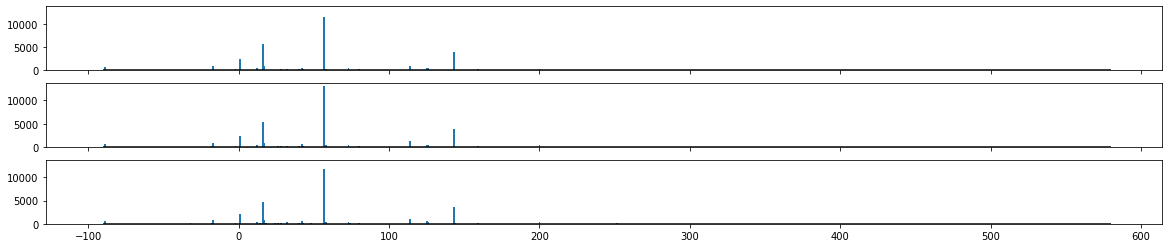

In [131]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 1, nrows=3, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianRA, width=1.2)
ax3.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianDiamide, width=1.2)
ax1.hlines(y=0,xmin=-90, xmax=580, color="k")
ax2.hlines(y=0,xmin=-90, xmax=580, color="k")
ax3.hlines(y=0,xmin=-90, xmax=580, color="k")

fig.set_size_inches(20,4)
# plt.ylim(0,4000)
plt.show()

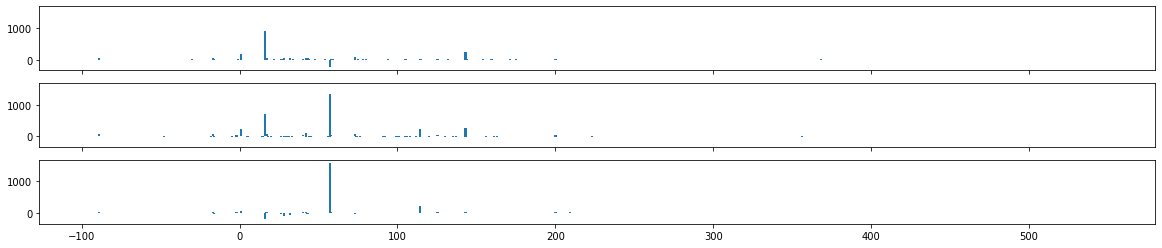

In [132]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 1, nrows=3, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
ax2.bar(x=g.Delta_mass, height=g.DiaDifference, width=1.4)
ax3.bar(x=g.Delta_mass, height=g.DiaRADifference, width=1.4)

fig.set_size_inches(20,4)
# plt.ylim(0,4000)
plt.show()

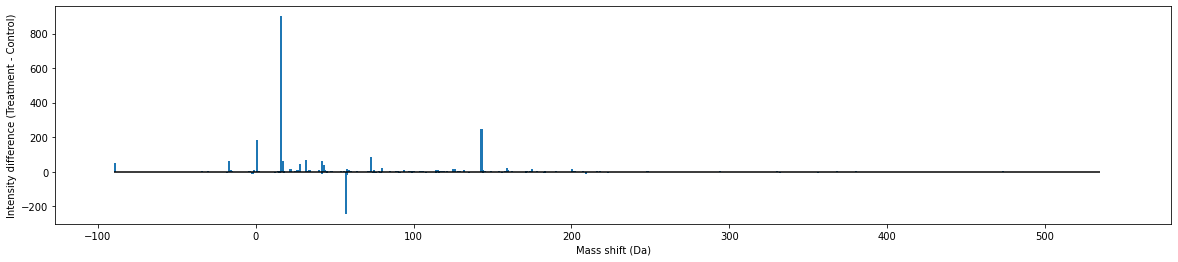

In [133]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [134]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [135]:
sorted

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
51,15.99,0.0,0.0,4643.507648,4848.894655,4828.815944,4612.498413,4770.327768,5516.013503,5417.841320,...,5670.597451,7090.048015,4892.122410,4791.057780,4770.327768,5670.597451,5483.583452,900.269683,713.255684,-187.013999
362,143.06,0.0,0.0,3518.380754,3623.830836,3765.385699,3706.679077,3343.954505,3913.415198,3902.252078,...,3978.894947,3871.754419,3892.186966,3479.866677,3623.830836,3871.754419,3902.252078,247.923583,278.421242,30.497659
34,0.98,0.0,0.0,2109.349807,2162.569781,2308.838735,2331.722396,1939.939528,2446.348095,2413.068202,...,2409.638248,2302.792846,2344.675571,1983.573299,2162.569781,2344.675571,2401.546571,182.105790,238.976790,56.871000
175,73.01,0.0,0.0,388.642270,477.272467,504.533588,457.309900,409.811354,498.812772,540.800293,...,543.660615,652.460958,469.799896,449.214246,457.309900,543.660615,519.657350,86.350714,62.347450,-24.003264
84,31.98,0.0,0.0,152.390859,168.083776,149.653175,149.969427,138.055693,202.752945,177.071018,...,216.125500,323.312999,148.272000,142.615121,149.969427,216.125500,173.347803,66.156074,23.378376,-42.777697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,-2.02,0.0,0.0,238.804430,219.736449,232.584768,142.250979,220.571370,208.140572,254.612248,...,222.972993,203.682495,204.034847,208.763679,220.571370,208.763679,252.461015,-11.807691,31.889645,43.697336
107,42.05,0.0,0.0,51.749769,52.536176,51.854971,50.953458,22.357960,36.655112,43.806943,...,42.791876,37.788838,38.746798,17.527463,51.749769,38.519182,36.655112,-13.230588,-15.094658,-1.864070
521,209.02,0.0,0.0,54.197528,35.668023,46.110146,17.670124,59.636020,48.372039,52.613754,...,32.438325,22.896129,29.945491,31.788483,46.110146,31.788483,52.613754,-14.321663,6.503608,20.825271
140,58.04,0.0,0.0,141.605144,164.509325,123.791500,126.556535,87.081159,94.337330,162.505852,...,153.396389,93.870999,163.508819,105.480881,126.556535,105.480881,128.321787,-21.075653,1.765253,22.840906


In [136]:
PXD014381[PXD014381["Delta_mass"] == 59.02]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,...,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,Modifications,Delta_mass
138,AAASMGDTLSEQQLGDSDIPVIVYR4|[472]AEC-MAEC[S],AAASMGDTLSEQQLGDSDIPVIVYR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
466,AASAAAASAAAASAASGSPGPGEGSAGGEK13|[472]AEC-MAEC[S],AASAAAASAAAASAASGSPGPGEGSAGGEK,TIF1B_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
794,ADLSLADALTEPSPDIEGEIKR4|[472]AEC-MAEC[S],ADLSLADALTEPSPDIEGEIKR,MAP4_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
3208,AQDPSEVLTMLTNETGFEISSSDATVK9|[472]AEC-MAEC[T],AQDPSEVLTMLTNETGFEISSSDATVK,ILF2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
3542,ASLSLAPVNIFK2|[472]AEC-MAEC[S],ASLSLAPVNIFK,TCPB_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36035,VLVIGCGNSELSEQLYDVGYR9|[472]AEC-MAEC[S],VLVIGCGNSELSEQLYDVGYR,EFNMT_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
36067,VLYDAEISQIHQSVTDTNVILSMDNSR8|[472]AEC-MAEC[S],VLYDAEISQIHQSVTDTNVILSMDNSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
36134,VMVDSLVEQEIQTSVATLDETEELPR13|[472]AEC-MAEC[T],VMVDSLVEQEIQTSVATLDETEELPR,NU107_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02
37312,VVSPIIDVINMDNFQYVGASADLK3|[472]AEC-MAEC[S],VVSPIIDVINMDNFQYVGASADLK,GALT2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[472],59.02


In [137]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
51,15.99,0.0,0.0,4643.507648,4848.894655,4828.815944,4612.498413,4770.327768,5516.013503,5417.841320,...,5670.597451,7090.048015,4892.122410,4791.057780,4770.327768,5670.597451,5483.583452,900.269683,713.255684,-187.013999
362,143.06,0.0,0.0,3518.380754,3623.830836,3765.385699,3706.679077,3343.954505,3913.415198,3902.252078,...,3978.894947,3871.754419,3892.186966,3479.866677,3623.830836,3871.754419,3902.252078,247.923583,278.421242,30.497659
34,0.98,0.0,0.0,2109.349807,2162.569781,2308.838735,2331.722396,1939.939528,2446.348095,2413.068202,...,2409.638248,2302.792846,2344.675571,1983.573299,2162.569781,2344.675571,2401.546571,182.105790,238.976790,56.871000
175,73.01,0.0,0.0,388.642270,477.272467,504.533588,457.309900,409.811354,498.812772,540.800293,...,543.660615,652.460958,469.799896,449.214246,457.309900,543.660615,519.657350,86.350714,62.347450,-24.003264
84,31.98,0.0,0.0,152.390859,168.083776,149.653175,149.969427,138.055693,202.752945,177.071018,...,216.125500,323.312999,148.272000,142.615121,149.969427,216.125500,173.347803,66.156074,23.378376,-42.777697
20,-17.03,0.0,0.0,741.549347,754.879712,808.729008,817.685036,642.641596,882.785267,839.700241,...,855.084559,810.471462,818.643465,644.170059,754.879712,818.643465,839.700241,63.763753,84.820529,21.056775
53,17.03,0.0,0.0,1059.313380,1089.660299,836.702285,875.864225,878.439585,962.380257,1028.943879,...,994.050364,941.813061,1010.649475,778.891871,878.439585,941.813061,965.904491,63.373477,87.464907,24.091430
105,42.01,0.0,0.0,526.392509,536.890329,618.012914,585.870793,516.870393,659.058404,659.510265,...,623.008120,583.403391,628.156364,526.895647,536.890329,600.102621,640.398731,63.212292,103.508402,40.296110
52,16.97,0.0,0.0,155.829953,167.609027,177.480033,200.323369,186.386976,260.342283,228.803093,...,227.894706,297.350675,200.430867,201.405124,177.480033,227.894706,228.803093,50.414674,51.323061,0.908387
1,-89.03,0.0,0.0,556.695556,534.873071,565.059258,589.521294,483.892530,655.991513,644.425669,...,664.455800,631.189738,606.261823,486.850254,556.695556,606.261823,644.425669,49.566267,87.730113,38.163846


RA - Control:

15.99: oxidation!

143.06: Nethylmaleimide + water (something sample prep read article)

0.98: Deamidation

73: Carbamidomethyl + Oxidation

31.98: two oxidations

-17: pyro-glu or loss of ammonia

17: ammonia

42.01: acetylation

17: Oxidation + Deamidation

-89.03: Met-loss + Acetyl

In [138]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
633,332.20,0.0,0.0,11.898887,13.793220,13.531664,7.730492,6.385422,7.442673,13.092369,...,2.910943,0.000000,13.206341,3.847892,11.898887,3.847892,13.014807,-8.050995,1.115920,9.166915
550,223.02,0.0,0.0,8.103678,8.855722,9.455630,8.045078,8.736217,4.274279,0.000000,...,0.000000,0.000000,8.102695,4.425347,8.736217,0.000000,4.274279,-8.736217,-4.461937,4.274279
188,76.00,0.0,0.0,14.161892,8.792119,8.029171,3.646582,12.450268,4.571472,11.475450,...,0.000000,7.506219,0.000000,0.000000,8.792119,0.000000,4.571472,-8.792119,-4.220647,4.571472
118,45.03,0.0,0.0,9.639554,5.037818,5.726713,9.717238,9.604518,4.586630,0.000000,...,0.000000,4.714965,0.000000,0.000000,9.604518,0.000000,0.000000,-9.604518,-9.604518,0.000000
106,42.02,0.0,0.0,102.626406,99.284197,88.103476,80.911108,53.379730,88.630848,110.630681,...,91.501070,77.791521,98.980238,61.908639,88.103476,77.791521,96.295911,-10.311955,8.192436,18.504391
30,-2.02,0.0,0.0,238.804430,219.736449,232.584768,142.250979,220.571370,208.140572,254.612248,...,222.972993,203.682495,204.034847,208.763679,220.571370,208.763679,252.461015,-11.807691,31.889645,43.697336
107,42.05,0.0,0.0,51.749769,52.536176,51.854971,50.953458,22.357960,36.655112,43.806943,...,42.791876,37.788838,38.746798,17.527463,51.749769,38.519182,36.655112,-13.230588,-15.094658,-1.864070
521,209.02,0.0,0.0,54.197528,35.668023,46.110146,17.670124,59.636020,48.372039,52.613754,...,32.438325,22.896129,29.945491,31.788483,46.110146,31.788483,52.613754,-14.321663,6.503608,20.825271
140,58.04,0.0,0.0,141.605144,164.509325,123.791500,126.556535,87.081159,94.337330,162.505852,...,153.396389,93.870999,163.508819,105.480881,126.556535,105.480881,128.321787,-21.075653,1.765253,22.840906
137,57.02,0.0,0.0,11277.094307,11728.236850,11924.798798,11884.967497,10209.705584,12499.089170,13453.831244,...,12729.825819,11483.972860,12537.447012,11075.179665,11728.236850,11483.972860,13073.120476,-244.263990,1344.883626,1589.147617


57.02: carbamidomethylation

58.04: reduced acrolein addition

209.02: CarbamidomethylDTT

42.05: Trimethyl

-2.02: Didehydro

42.02: AMidino or Guanidinaiton

45.03: Acetyl_heavy	

76: Ethanedithiol or cysteine mercaptoethanol

223.02: Chemical reaction with 2,4-dinitro-1-chloro benzene (DNCB)	+ carbamidomethyl

332.4: 	Levuglandinyl - lysine lactam adduct

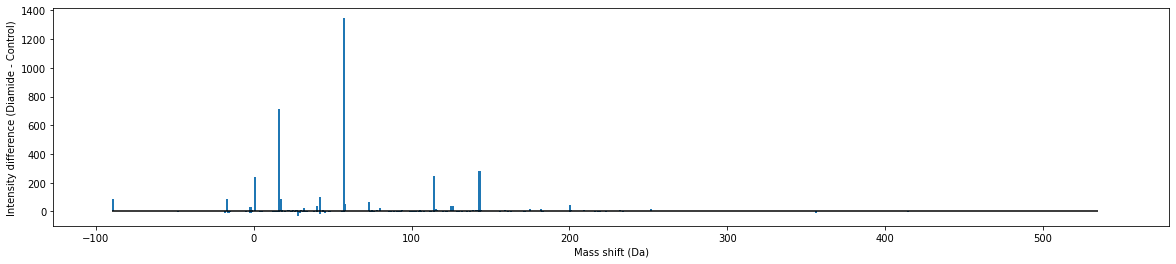

In [139]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.DiaDifference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Diamide - Control)")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [140]:
sorted = g.sort_values(by="DiaDifference", axis=0, ascending=False)

In [141]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
137,57.02,0.0,0.0,11277.094307,11728.236850,11924.798798,11884.967497,10209.705584,12499.089170,13453.831244,...,12729.825819,11483.972860,12537.447012,11075.179665,11728.236850,11483.972860,13073.120476,-244.263990,1344.883626,1589.147617
51,15.99,0.0,0.0,4643.507648,4848.894655,4828.815944,4612.498413,4770.327768,5516.013503,5417.841320,...,5670.597451,7090.048015,4892.122410,4791.057780,4770.327768,5670.597451,5483.583452,900.269683,713.255684,-187.013999
362,143.06,0.0,0.0,3518.380754,3623.830836,3765.385699,3706.679077,3343.954505,3913.415198,3902.252078,...,3978.894947,3871.754419,3892.186966,3479.866677,3623.830836,3871.754419,3902.252078,247.923583,278.421242,30.497659
278,114.04,0.0,0.0,926.813279,981.988805,1099.223463,1050.970515,871.103955,1117.483370,1229.686083,...,1092.840417,969.371608,1092.417756,989.999404,981.988805,989.999404,1229.686083,8.010600,247.697279,239.686679
34,0.98,0.0,0.0,2109.349807,2162.569781,2308.838735,2331.722396,1939.939528,2446.348095,2413.068202,...,2409.638248,2302.792846,2344.675571,1983.573299,2162.569781,2344.675571,2401.546571,182.105790,238.976790,56.871000
105,42.01,0.0,0.0,526.392509,536.890329,618.012914,585.870793,516.870393,659.058404,659.510265,...,623.008120,583.403391,628.156364,526.895647,536.890329,600.102621,640.398731,63.212292,103.508402,40.296110
1,-89.03,0.0,0.0,556.695556,534.873071,565.059258,589.521294,483.892530,655.991513,644.425669,...,664.455800,631.189738,606.261823,486.850254,556.695556,606.261823,644.425669,49.566267,87.730113,38.163846
53,17.03,0.0,0.0,1059.313380,1089.660299,836.702285,875.864225,878.439585,962.380257,1028.943879,...,994.050364,941.813061,1010.649475,778.891871,878.439585,941.813061,965.904491,63.373477,87.464907,24.091430
20,-17.03,0.0,0.0,741.549347,754.879712,808.729008,817.685036,642.641596,882.785267,839.700241,...,855.084559,810.471462,818.643465,644.170059,754.879712,818.643465,839.700241,63.763753,84.820529,21.056775
175,73.01,0.0,0.0,388.642270,477.272467,504.533588,457.309900,409.811354,498.812772,540.800293,...,543.660615,652.460958,469.799896,449.214246,457.309900,543.660615,519.657350,86.350714,62.347450,-24.003264


Diamide - Control:

57: Carbamidomethyl

16: Oxidation

143: Nethylmaleimide+water	

114.04: Ubiquitination

0.98: Deamidation

42.01: acetylation

-89: Met-loss+Acetyl

17: Oxidation + deamidation

-17: Pyro-glu from Q or ammonia loss

73: Carbamidomethyl + Oxidation

In [142]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
262,108.02,0.0,0.0,6.428866,10.314834,6.416255,10.520725,10.666018,0.000000,0.000000,...,4.331309,4.287012,4.108981,4.361419,10.314834,4.287012,3.313419,-6.027822,-7.001415,-0.973594
397,156.12,0.0,0.0,14.186651,24.881693,13.978881,20.118851,21.636610,11.355053,16.136372,...,15.343242,15.574473,23.464255,17.316286,20.118851,15.574473,12.882318,-4.544378,-7.236533,-2.692155
29,-2.03,0.0,0.0,7.080971,8.023797,20.396805,16.892867,20.909376,19.644658,3.814079,...,14.607797,18.015097,23.390598,12.186704,16.892867,18.015097,8.575392,1.122229,-8.317475,-9.439705
642,356.19,0.0,0.0,8.452009,13.427696,12.690447,12.693000,8.251857,3.555661,3.421932,...,4.670141,8.704384,3.838994,8.721024,12.690447,7.887463,3.555661,-4.802983,-9.134786,-4.331803
118,45.03,0.0,0.0,9.639554,5.037818,5.726713,9.717238,9.604518,4.586630,0.000000,...,0.000000,4.714965,0.000000,0.000000,9.604518,0.000000,0.000000,-9.604518,-9.604518,0.000000
23,-15.99,0.0,0.0,41.942456,42.916388,42.746656,40.198905,40.428555,27.271818,31.824919,...,50.902640,46.665838,52.805731,56.438755,41.942456,50.902640,32.132095,8.960184,-9.810361,-18.770545
76,29.02,0.0,0.0,19.005649,19.446323,27.527290,16.369674,10.896862,12.009000,8.992434,...,17.292932,21.780758,13.589498,17.463807,19.005649,17.292932,8.860177,-1.712717,-10.145472,-8.432755
17,-18.01,0.0,0.0,153.249909,183.204260,178.421247,185.952566,127.064539,158.311352,178.971079,...,172.571458,194.484305,188.279733,156.770344,178.421247,172.571458,166.708930,-5.849789,-11.712317,-5.862528
107,42.05,0.0,0.0,51.749769,52.536176,51.854971,50.953458,22.357960,36.655112,43.806943,...,42.791876,37.788838,38.746798,17.527463,51.749769,38.519182,36.655112,-13.230588,-15.094658,-1.864070
72,27.99,0.0,0.0,148.128625,161.973207,172.175109,173.326935,141.310985,130.594609,120.688370,...,209.518782,279.474593,169.066038,160.081452,161.973207,209.518782,130.594609,47.545575,-31.378598,-78.924173


28: Formylation

42.05: Acetylation

-18: dehydration

29.02: ethyl+deamidated

-16: reduction

45: Acetyl_heavy

356.19: Biotin polyethyleneoxide amine	

-2.03: oxidation + loss of ammonia (15N)

156.12: 4HNE

108.02: HydroxymethylOP

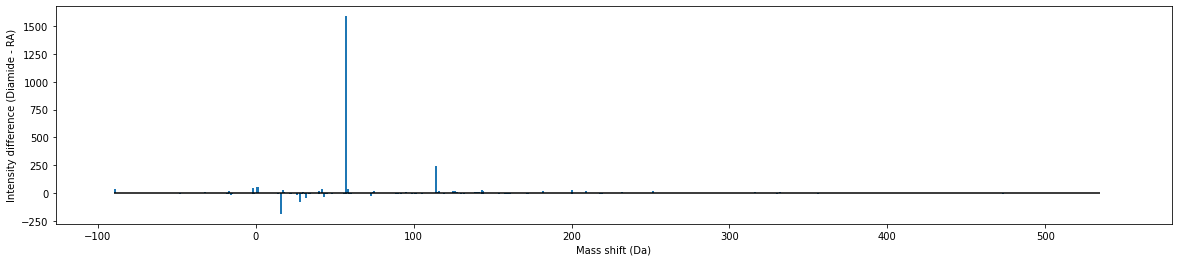

In [143]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.DiaRADifference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Diamide - RA)")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [144]:
sorted = g.sort_values(by="DiaRADifference", axis=0, ascending=False)

In [145]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
137,57.02,0.0,0.0,11277.094307,11728.236850,11924.798798,11884.967497,10209.705584,12499.089170,13453.831244,...,12729.825819,11483.972860,12537.447012,11075.179665,11728.236850,11483.972860,13073.120476,-244.263990,1344.883626,1589.147617
278,114.04,0.0,0.0,926.813279,981.988805,1099.223463,1050.970515,871.103955,1117.483370,1229.686083,...,1092.840417,969.371608,1092.417756,989.999404,981.988805,989.999404,1229.686083,8.010600,247.697279,239.686679
34,0.98,0.0,0.0,2109.349807,2162.569781,2308.838735,2331.722396,1939.939528,2446.348095,2413.068202,...,2409.638248,2302.792846,2344.675571,1983.573299,2162.569781,2344.675571,2401.546571,182.105790,238.976790,56.871000
30,-2.02,0.0,0.0,238.804430,219.736449,232.584768,142.250979,220.571370,208.140572,254.612248,...,222.972993,203.682495,204.034847,208.763679,220.571370,208.763679,252.461015,-11.807691,31.889645,43.697336
105,42.01,0.0,0.0,526.392509,536.890329,618.012914,585.870793,516.870393,659.058404,659.510265,...,623.008120,583.403391,628.156364,526.895647,536.890329,600.102621,640.398731,63.212292,103.508402,40.296110
1,-89.03,0.0,0.0,556.695556,534.873071,565.059258,589.521294,483.892530,655.991513,644.425669,...,664.455800,631.189738,606.261823,486.850254,556.695556,606.261823,644.425669,49.566267,87.730113,38.163846
138,58.00,0.0,0.0,335.807497,367.886338,390.100486,340.181177,330.307282,403.176722,392.969241,...,405.057848,357.618335,415.131387,293.232696,340.181177,357.618335,392.969241,17.437158,52.788063,35.350905
362,143.06,0.0,0.0,3518.380754,3623.830836,3765.385699,3706.679077,3343.954505,3913.415198,3902.252078,...,3978.894947,3871.754419,3892.186966,3479.866677,3623.830836,3871.754419,3902.252078,247.923583,278.421242,30.497659
504,200.08,0.0,0.0,302.882158,306.163589,295.887321,315.511078,288.900832,352.016332,346.352699,...,342.274253,333.257253,318.962190,311.686133,302.882158,318.962190,346.352699,16.080032,43.470541,27.390509
53,17.03,0.0,0.0,1059.313380,1089.660299,836.702285,875.864225,878.439585,962.380257,1028.943879,...,994.050364,941.813061,1010.649475,778.891871,878.439585,941.813061,965.904491,63.373477,87.464907,24.091430


Diamide - RA:

57.02: Carbamidomethyl

114: many possibilities, mostly with carbamidomethylation

0.98: Deamidation

-2: Didehydro or oxidation + glu => pyro-glu

42.01: Acetylation

-89.03: Met-loss + Acetyl

58: Carbamidomethylation + Acetyl

143.06: Nethylmaleimide+water

200.08: Nethylmaleimide+water + carbamidomethylation

17.03: Ammonium	

In [146]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
101,40.03,0.0,0.0,15.104524,15.204967,10.875254,9.622019,12.651020,9.060690,10.333109,...,15.638336,19.962684,20.803756,19.367200,12.651020,19.367200,10.463691,6.716181,-2.187328,-8.903509
29,-2.03,0.0,0.0,7.080971,8.023797,20.396805,16.892867,20.909376,19.644658,3.814079,...,14.607797,18.015097,23.390598,12.186704,16.892867,18.015097,8.575392,1.122229,-8.317475,-9.439705
503,200.07,0.0,0.0,36.577893,37.003276,34.719124,40.391916,28.849730,29.841225,26.824337,...,44.132662,27.362790,45.758292,40.473997,36.577893,40.473997,29.841225,3.896104,-6.736668,-10.632772
66,26.02,0.0,0.0,121.692990,124.043486,146.836500,132.204315,106.133221,112.510016,133.869446,...,133.869378,131.639715,138.147413,133.255160,124.043486,133.869378,120.230126,9.825891,-3.813360,-13.639252
23,-15.99,0.0,0.0,41.942456,42.916388,42.746656,40.198905,40.428555,27.271818,31.824919,...,50.902640,46.665838,52.805731,56.438755,41.942456,50.902640,32.132095,8.960184,-9.810361,-18.770545
175,73.01,0.0,0.0,388.642270,477.272467,504.533588,457.309900,409.811354,498.812772,540.800293,...,543.660615,652.460958,469.799896,449.214246,457.309900,543.660615,519.657350,86.350714,62.347450,-24.003264
108,43.01,0.0,0.0,136.969965,114.233548,151.009088,138.096047,142.021391,140.523649,143.899482,...,243.891038,266.138516,177.671474,159.428537,138.096047,177.671474,143.899482,39.575427,5.803435,-33.771992
84,31.98,0.0,0.0,152.390859,168.083776,149.653175,149.969427,138.055693,202.752945,177.071018,...,216.125500,323.312999,148.272000,142.615121,149.969427,216.125500,173.347803,66.156074,23.378376,-42.777697
72,27.99,0.0,0.0,148.128625,161.973207,172.175109,173.326935,141.310985,130.594609,120.688370,...,209.518782,279.474593,169.066038,160.081452,161.973207,209.518782,130.594609,47.545575,-31.378598,-78.924173
51,15.99,0.0,0.0,4643.507648,4848.894655,4828.815944,4612.498413,4770.327768,5516.013503,5417.841320,...,5670.597451,7090.048015,4892.122410,4791.057780,4770.327768,5670.597451,5483.583452,900.269683,713.255684,-187.013999


57.02: carbamidomethylation

-17: Pyro-Glu & loss of ammonia

114.04: ubiquitination

209: CarbamidomethylDTT

40: G-H1

-18: Dehydration

115.02: Cleavage product of EGS protein crosslinks by hydroylamine treatment	

-89: Met-loss+Acetyl	

171.06: ubiquitination + carbamidomethyl

59.02: aminoethylcysteine




# PXD024844

In [147]:
cols = ['Intensity_20200828_1_5ug_testis_ingwar',
       'Intensity_20200828_1_5ug_testis_obelisk',
       'Intensity_20200828_1_5ug_testis_timon',
       'Intensity_20200828_1_5ug_testis_wonny',
       'Intensity_20200828_1_5ug_testis_bellamo',
       'Intensity_20200828_1_5ug_testis_bendix',
       'Intensity_20200828_1_5ug_testis_ilineus',
       'Intensity_20200828_1_5ug_testis_kalonso',
       'Intensity_20200828_1_5ug_testis_primat',
       'Intensity_20200828_1_5ug_testis_vitali']

In [148]:
PXD024844 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD024844/quant/QuantifiedPeptides.tsv", sep="\t")
PXD024844.drop(list(PXD024844.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD024844 = PXD024844[~PXD024844["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [149]:
OA.quantile_transform(PXD024844, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25
0,AAAAAAAAAAAAAASAGGK15|[9999514]HexNAc[S],AAAAAAAAAAAAAASAGGK,A0A5F4VSA7_CALJA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.900439,NaN,5.293098,NaN
1,AAAAAAAAAAAAAASAGGKnan,AAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAAAVSRnan,AAAAAAAAAAAVSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAAACAAGGR11|Gly->Cys[G],AAAAAAAAAACAAGGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAAAGAAGGR0|[1]Acetyl[N-TERM],AAAAAAAAAAGAAGGR,NaN,NaN,NaN,6.426570,NaN,6.203039,6.368506,NaN,6.458357,6.328460,6.481025,6.337011,6.001437,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146977,YYYVCQYCPAGNNVQTK5|[4]carbamidomethyl[C]|8|[13...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146978,YYYVCQYCPAGNNVQTK5|[4]carbamidomethyl[C]|8|[4]...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,5.410580,6.060309,5.851878,6.039844,5.885314,5.827445,5.900102,5.985026,5.983836,5.964641,NaN
146979,YYYVCQYCPAGNNVQTK5|[4]carbamidomethyl[C]|8|[6]...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146980,YYYVCQYCPAGNNVQTK8|[4]carbamidomethyl[C]|5|[6]...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


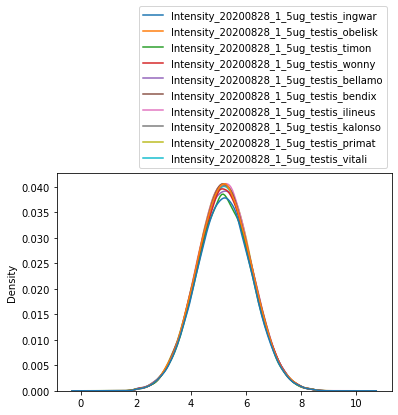

In [150]:
ax = sns.kdeplot(data=PXD024844[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [151]:
PXD024844["Modifications"] = PXD024844["Sequence"].apply(modifications)
PXD024844["Delta_mass"] = PXD024844["Sequence"].apply(get_delta_mass)

In [152]:
No_zero = PXD024844[PXD024844["Delta_mass"] != 0]

In [153]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [154]:
YoungID = ['Intensity_20200828_1_5ug_testis_bellamo','Intensity_20200828_1_5ug_testis_bendix','Intensity_20200828_1_5ug_testis_ilineus','Intensity_20200828_1_5ug_testis_kalonso','Intensity_20200828_1_5ug_testis_primat','Intensity_20200828_1_5ug_testis_vitali']
OldID = ['Intensity_20200828_1_5ug_testis_ingwar','Intensity_20200828_1_5ug_testis_obelisk','Intensity_20200828_1_5ug_testis_timon','Intensity_20200828_1_5ug_testis_wonny',]

In [155]:

from statistics import median


g['medianYoung']=g.apply(lambda x:median([x[c] for c in YoungID]),axis=1)
g["medianOld"]=g.apply(lambda x:median([x[c] for c in OldID]), axis=1)
# g['Quotient']=(g["medianOld"] - g["medianYoung"]) / max([g["medianYoung"], g["medianOld"]])
# g["Quotient"] = ((g["medianOld"] - g["medianYoung"])/ g["medianYoung"]).where( g["medianYoung"] >= g["medianOld"], other=(g["medianOld"] - g["medianYoung"])/ g["medianOld"])
# g["Quotient"] = ((g["medianOld"] - g["medianYoung"])/ g["medianOld"]).where( g["medianYoung"] < g["medianOld"])
g["Difference"] = (g["medianOld"] - g["medianYoung"])

### Plots

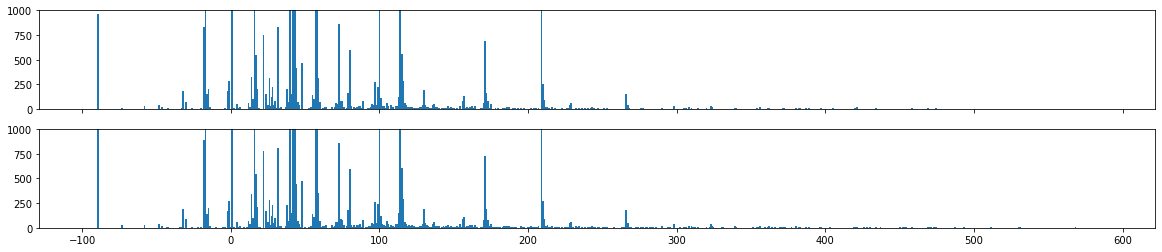

In [156]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="medianOld")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianOld, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianYoung, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,1000)
plt.show()

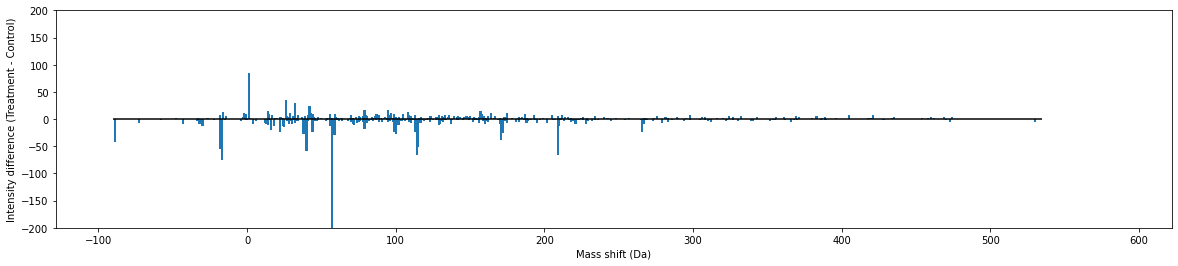

In [157]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
plt.ylim(-200,200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [158]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [159]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25,medianYoung,medianOld,Difference
46,0.98,0.0,0.0,12892.210757,12786.846131,12382.240019,12708.748169,12693.367256,12352.046587,12883.921146,12719.017470,12267.280424,12632.163568,0.0,12662.765412,12747.797150,85.031738
90,26.02,0.0,0.0,313.082712,292.722950,311.394642,343.411479,251.622743,245.004192,303.027950,231.004419,321.846255,310.353718,0.0,277.325347,312.238677,34.913330
110,31.99,0.0,0.0,823.809453,893.122682,799.862557,840.560462,747.947320,843.727994,761.716373,713.261883,886.400864,871.378972,0.0,802.722183,832.184958,29.462774
136,42.01,0.0,0.0,2233.336863,2299.575936,2278.250376,2287.628633,2173.101929,2316.125071,2257.801485,2260.150310,2355.018937,2217.666848,0.0,2258.975898,2282.939504,23.963607
137,42.02,0.0,0.0,639.063396,618.358888,557.420945,663.718906,598.273886,601.948956,611.303925,652.349839,654.462335,609.727701,0.0,610.515813,628.711142,18.195329
267,78.99,0.0,0.0,101.421365,114.381045,123.110277,106.512809,86.716395,93.044328,102.114858,93.652811,98.036735,85.546504,0.0,93.348569,110.446927,17.098358
322,94.97,0.0,0.0,33.782999,59.239528,45.686251,54.190653,33.561411,45.146713,25.254662,31.842735,46.589646,32.936673,0.0,33.249042,49.938452,16.689410
64,13.98,0.0,0.0,188.753084,194.064629,149.983970,213.081789,208.236390,164.591205,154.572415,175.512606,219.979602,176.294913,0.0,175.903759,191.408856,15.505097
598,157.05,0.0,0.0,106.091259,149.048212,125.190202,133.288402,111.173808,112.018409,130.195639,98.520690,116.317655,136.356552,0.0,114.168032,129.239302,15.071270
378,108.00,0.0,0.0,37.617309,36.804485,50.103794,41.519750,19.617281,37.690480,30.302885,10.552731,36.883271,22.024932,0.0,26.163908,39.568530,13.404621


0.98: Deamidation

26: Acetaldehyde +26

32: Dioxidation (sure)

42: Acetylation

42.02: Guanidination

79: Carbamidomethyl + Replacement of 2 protons by magnesium	

95: Carbamidomethyl + Replacement of 2 protons by calcium

13.98: tryptophan oxidation to oxolactone or proline oxidation to pyroglutamic acid or carbonylation

157: 2 carbamidomethylation + carbamyl

108: 	O-Dimethylphosphate or O-ethylphosphate

In [160]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25,medianYoung,medianOld,Difference
193,59.02,0.0,0.0,319.643475,318.041568,360.195617,312.298245,321.747976,352.389612,344.820947,377.932175,316.454276,388.103417,0.0,348.605280,318.842521,-29.762759
658,171.06,0.0,0.0,610.197338,710.526330,673.521386,782.734847,672.005178,753.771701,744.390804,660.689548,750.048945,715.525977,0.0,729.958391,692.023858,-37.934532
1,-89.03,0.0,0.0,962.697613,999.248064,909.636802,954.772028,1090.745890,933.029788,1003.152219,940.778096,998.825134,1027.784554,0.0,1000.988676,958.734821,-42.253856
407,115.02,0.0,0.0,526.949283,556.630202,569.902541,551.332967,573.174459,599.031857,610.075908,616.577457,586.595113,622.907366,0.0,604.553882,553.981584,-50.572298
21,-18.01,0.0,0.0,820.577492,926.840996,791.526576,847.150101,802.320941,914.713972,886.194792,845.073130,890.811311,900.528718,0.0,888.503052,833.863796,-54.639255
131,39.99,0.0,0.0,1474.590289,1763.657034,1669.032363,1701.715444,1646.503316,1740.233031,1669.543032,1802.884496,1761.823911,1747.293433,0.0,1743.763232,1685.373903,-58.389329
405,114.04,0.0,0.0,4869.622024,5968.678712,5761.811833,5837.848163,5695.842316,6017.441303,6016.416168,5875.939801,5856.184597,5737.797229,0.0,5866.062199,5799.829998,-66.232201
786,209.02,0.0,0.0,1334.151509,1132.330158,894.302891,1205.642586,1352.631225,1098.391927,1269.104853,1364.002792,1073.222546,1202.286816,0.0,1235.695834,1168.986372,-66.709462
24,-17.03,0.0,0.0,2389.642819,2603.995626,2367.633941,2436.998566,2454.892252,2455.053877,2440.630396,2538.495356,2523.322922,2563.010924,0.0,2489.188400,2413.320692,-75.867707
188,57.02,0.0,0.0,35184.966011,41231.782251,40114.762974,40652.467807,40491.124671,42226.142819,42805.479746,42037.425071,41806.618427,41209.296029,0.0,41922.021749,40383.615391,-1538.406358


57: carbamidomethylation

-17.03; loss of ammonia

114: ubiquitination

209: CarbamidomethylDTT

39.99: dioxidation

-18.01: dehydration or pyro-glu from glu

115: Xlink:EGS

-89: met-loss+acetyl

171.06: carbamidomethyl + ubiquitnation

59.02: AEC-MAEC	

In [161]:
PXD024844[PXD024844["Delta_mass"] == 57.02]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25,Modifications,Delta_mass
50,AAAAALGSSSGSASPAVAELCQNTPETFLEASK21|[4]carbami...,AAAAALGSSSGSASPAVAELCQNTPETFLEASK,NaN,NaN,NaN,3.828661,NaN,NaN,4.493469,4.321498,NaN,4.095314,NaN,4.68670,NaN,NaN,"[4, 999911]",57.02
51,AAAAALGSSSGSASPAVAELCQNTPETFLEASK21|[4]carbami...,AAAAALGSSSGSASPAVAELCQNTPETFLEASK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 999915]",57.02
54,AAAAALGSSSGSASPAVAELCQNTPETFLEASK21|[4]carbami...,AAAAALGSSSGSASPAVAELCQNTPETFLEASK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 999915]",57.02
71,AAAADHRQELIECVANSDEQLGEMFLEEK13|[4]carbamidome...,AAAADHRQELIECVANSDEQLGEMFLEEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
92,AAAANLCPGDVILAIDGFGTESMTHADAQDR7|[4]carbamidom...,AAAANLCPGDVILAIDGFGTESMTHADAQDR,NaN,NaN,NaN,5.432270,4.939979,5.444899,5.020117,4.874907,4.908473,4.663206,4.722497,4.84488,4.563318,NaN,[4],57.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146918,YYNDCYAVLR5|[4]carbamidomethyl[C],YYNDCYAVLR,F6Z9S9_CALJA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
146926,YYQHLYSIHLAEQSEDCTMQLADHIK17|[4]carbamidomethy...,YYQHLYSIHLAEQSEDCTMQLADHIK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.552131,5.112169,NaN,NaN,NaN,NaN,[4],57.02
146932,YYSDLFSYCDIESTK9|[4]carbamidomethyl[C],YYSDLFSYCDIESTK,A0A8J8YP46_CALJA,NaN,NaN,5.574913,5.279952,5.698038,5.808756,5.864247,5.578300,5.769101,4.617062,NaN,4.872325,NaN,[4],57.02
146933,YYSDLFSYCDIESTKK9|[4]carbamidomethyl[C],YYSDLFSYCDIESTKK,A0A8J8YP46_CALJA,NaN,NaN,4.223249,NaN,4.749258,4.227017,4.817631,NaN,4.793321,4.612019,NaN,NaN,NaN,[4],57.02
